In [7]:
import gc
import os
import random

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.cluster import KMeans
from tqdm import tqdm

sns.set(style='darkgrid')
SEEDS = 42	

In [2]:
def rmse(y_true, y_pred):
    return (mean_squared_error(y_true, y_pred))** .5

In [3]:
# treemodel_wrapper
class TreeModel:
    def __init__(self, model_type):
        self.model_type = model_type
        self.tr_data = None
        self.vl_data = None
        self.model = None
    
    def train(self, params, train_x, train_y, valid_x=None, valid_y=None, num_round=None, early_stopping=None, verbose=None):
        if self.model_type == 'lgb':
            self.tr_data = lgb.Dataset(train_x, label=train_y)
            self.vl_data = lgb.Dataset(valid_x, label=valid_y)
            self.model = lgb.train(params, self.tr_data, valid_sets=[self.tr_data, self.vl_data],
                                   num_boost_round=num_round, early_stopping_rounds=early_stopping,verbose_eval=verbose)
            
        if self.model_type == 'rf_reg':
            self.train_x = train_x
            self.train_y = train_y
            self.model = RandomForestRegressor(**params).fit(self.train_x, self.train_y)
            
        if self.model_type == 'xgb':
            self.tr_data = xgb.DMatrix(train_x, train_y)
            self.vl_data = xgb.DMatrix(valid_x, valid_y)
            self.model = xgb.train(params, self.tr_data, num_boost_round=num_round,
                                   evals=[(self.tr_data, 'train'), (self.vl_data, 'val')], 
                                   verbose_eval=verbose, early_stopping_rounds=early_stopping)
            
        if self.model_type == 'cat':
            params['num_boost_round'] = num_round
            self.cat_cols = list(train_x.select_dtypes(include='object').columns)
            self.tr_data = Pool(train_x, train_y, cat_features=self.cat_cols)
            self.vl_data = Pool(valid_x, valid_y, cat_features=self.cat_cols)
            self.model = CatBoost(params).fit(self.tr_data, eval_set=self.vl_data,
                                                early_stopping_rounds=early_stopping, verbose=verbose, use_best_model=True)
            
            return self.model
            
    
    def predict(self,X):
        if self.model_type == 'lgb':
            return self.model.predict(X, num_iteration=self.model.best_iteration)
        
        if self.model_type == 'rf_reg':
            return self.model.predict(X)
        
        if self.model_type == 'xgb':
            X_DM = xgb.DMatrix(X)
            return self.model.predict(X_DM)
        
        if self.model_type == 'cat':
            X_pool = Pool(X, cat_features=self.cat_cols)
            return self.model.predict(X_pool)
    
    @property
    def feature_names_(self):
        if self.model_type == 'lgb':
            return self.model.feature_name()
        
        if self.model_type == 'rf_reg':
            return self.train_x.columns
        
        if self.model_type == 'xgb':
            return list(self.model.get_score(importance_type='gain').keys())
        
        if self.model_type == 'cat':
            return self.model.feature_names_
    
    @property
    def feature_importances_(self):
        if self.model_type == 'lgb':
            return self.model.feature_importance(importance_type='gain')
        
        if self.model_type == 'rf_reg':
            return self.model.feature_importances_
        
        if self.model_type == 'xgb':
            return list(self.model.get_score(importance_type='gain').values())
        
        if self.model_type == 'cat':
            return self.model.feature_importances_

In [4]:
path = '/Users/miwanokentarou/workspace/Kaggle/stanford_corona_wakutin/01_input'
train = pd.read_json(f'{path}/train.json',lines=True)
test = pd.read_json(f'{path}/test.json', lines=True)
submission = pd.read_csv(f'{path}/sample_submission.csv')

In [5]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


# Preproces

In [6]:
train_data = []
for mol_id in train['id'].unique():
    sample_data = train.loc[train['id'] == mol_id]
    sample_seq_length = sample_data.seq_length.values[0]
    
    for i in range(68):
        sample_dict = {'id' : sample_data['id'].values[0],
                       'id_seqpos' : sample_data['id'].values[0] + '_' + str(i),
                       'sequence' : sample_data['sequence'].values[0][i],
                       'structure' : sample_data['structure'].values[0][i],
                       'predicted_loop_type' : sample_data['predicted_loop_type'].values[0][i],
                       'reactivity' : sample_data['reactivity'].values[0][i],
                       'reactivity_error' : sample_data['reactivity_error'].values[0][i],
                       'deg_Mg_pH10' : sample_data['deg_Mg_pH10'].values[0][i],
                       'deg_error_Mg_pH10' : sample_data['deg_error_Mg_pH10'].values[0][i],
                       'deg_pH10' : sample_data['deg_pH10'].values[0][i],
                       'deg_error_pH10' : sample_data['deg_error_pH10'].values[0][i],
                       'deg_Mg_50C' : sample_data['deg_Mg_50C'].values[0][i],
                       'deg_error_Mg_50C' : sample_data['deg_error_Mg_50C'].values[0][i],
                       'deg_50C' : sample_data['deg_50C'].values[0][i],
                       'deg_error_50C' : sample_data['deg_error_50C'].values[0][i]}
        
        
        shifts = [1,2,3,4,5]
        shift_cols = ['sequence', 'structure', 'predicted_loop_type']
        for shift,col in itertools.product(shifts, shift_cols):
            if i - shift >= 0:
                sample_dict['b'+str(shift)+'_'+col] = sample_data[col].values[0][i-shift]
            else:
                sample_dict['b'+str(shift)+'_'+col] = -1
            
            if i + shift <= sample_seq_length - 1:
                sample_dict['a'+str(shift)+'_'+col] = sample_data[col].values[0][i+shift]
            else:
                sample_dict['a'+str(shift)+'_'+col] = -1
        
        
        train_data.append(sample_dict)
train_data = pd.DataFrame(train_data)
train_data.head()

,id,id_seqpos,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,...,b4_structure,a4_structure,b4_predicted_loop_type,a4_predicted_loop_type,b5_sequence,a5_sequence,b5_structure,a5_structure,b5_predicted_loop_type,a5_predicted_loop_type
0,id_001f94081,id_001f94081_0,G,.,E,0.3297,0.1359,0.7556,0.2613,2.3375,...,-1,.,-1,E,-1,A,-1,(,-1,S
1,id_001f94081,id_001f94081_1,G,.,E,1.5693,0.2070,2.9830,0.3842,3.5060,...,-1,(,-1,S,-1,G,-1,(,-1,S
2,id_001f94081,id_001f94081_2,A,.,E,1.1227,0.1633,0.2526,0.1372,0.3008,...,-1,(,-1,S,-1,C,-1,(,-1,S
3,id_001f94081,id_001f94081_3,A,.,E,0.8686,0.1452,1.3789,0.2531,1.0108,...,-1,(,-1,S,-1,U,-1,(,-1,S
4,id_001f94081,id_001f94081_4,A,.,E,0.7217,0.1314,0.6376,0.1798,0.2635,...,.,(,E,S,-1,C,-1,(,-1,S


In [11]:
train_data.head(50)

,id,id_seqpos,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,...,b4_structure,a4_structure,b4_predicted_loop_type,a4_predicted_loop_type,b5_sequence,a5_sequence,b5_structure,a5_structure,b5_predicted_loop_type,a5_predicted_loop_type
0,id_001f94081,id_001f94081_0,1,0,1,0.3297,0.1359,0.7556,0.2613,2.3375,...,-1,0,-1,1,-1,0,-1,1,-1,0
1,id_001f94081,id_001f94081_1,1,0,1,1.5693,0.2070,2.9830,0.3842,3.5060,...,-1,1,-1,0,-1,1,-1,1,-1,0
2,id_001f94081,id_001f94081_2,0,0,1,1.1227,0.1633,0.2526,0.1372,0.3008,...,-1,1,-1,0,-1,2,-1,1,-1,0
3,id_001f94081,id_001f94081_3,0,0,1,0.8686,0.1452,1.3789,0.2531,1.0108,...,-1,1,-1,0,-1,3,-1,1,-1,0
4,id_001f94081,id_001f94081_4,0,0,1,0.7217,0.1314,0.6376,0.1798,0.2635,...,0,1,1,0,-1,2,-1,1,-1,0
5,id_001f94081,id_001f94081_5,0,1,0,0.4384,0.1050,0.3313,0.1371,0.3403,...,0,1,1,0,1,3,0,1,1,0
6,id_001f94081,id_001f94081_6,1,1,0,0.2560,0.0821,0.6763,0.1736,0.5617,...,0,1,1,0,1,0,0,0,1,2
7,id_001f94081,id_001f94081_7,2,1,0,0.3364,0.0964,0.7525,0.1791,0.6810,...,0,0,1,2,0,0,0,0,1,2
8,id_001f94081,id_001f94081_8,3,1,0,0.2168,0.0756,0.2080,0.1056,0.0530,...,0,0,1,2,0,3,0,0,1,2
9,id_001f94081,id_001f94081_9,2,1,0,0.3583,0.1087,0.8908,0.1896,0.5348,...,1,0,0,2,0,0,0,0,1,2


In [8]:
test_data = []
for mol_id in test['id'].unique():
    sample_data = test.loc[test['id'] == mol_id]
    sample_seq_length = sample_data.seq_length.values[0]
    for i in range(sample_seq_length):
        sample_dict = {'id' : sample_data['id'].values[0],
                       'id_seqpos' : sample_data['id'].values[0] + '_' + str(i),
                       'sequence' : sample_data['sequence'].values[0][i],
                       'structure' : sample_data['structure'].values[0][i],
                       'predicted_loop_type' : sample_data['predicted_loop_type'].values[0][i]}
        
        shifts = [1,2,3,4,5]
        shift_cols = ['sequence', 'structure', 'predicted_loop_type']
        for shift,col in itertools.product(shifts, shift_cols):
            if i - shift >= 0:
                sample_dict['b'+str(shift)+'_'+col] = sample_data[col].values[0][i-shift]
            else:
                sample_dict['b'+str(shift)+'_'+col] = -1
            
            if i + shift <= sample_seq_length - 1:
                sample_dict['a'+str(shift)+'_'+col] = sample_data[col].values[0][i+shift]
            else:
                sample_dict['a'+str(shift)+'_'+col] = -1
        
        test_data.append(sample_dict)
test_data = pd.DataFrame(test_data)
test_data.head()

,id,id_seqpos,sequence,structure,predicted_loop_type,b1_sequence,a1_sequence,b1_structure,a1_structure,b1_predicted_loop_type,...,b4_structure,a4_structure,b4_predicted_loop_type,a4_predicted_loop_type,b5_sequence,a5_sequence,b5_structure,a5_structure,b5_predicted_loop_type,a5_predicted_loop_type
0,id_00073f8be,id_00073f8be_0,G,.,E,-1,G,-1,.,-1,...,-1,.,-1,E,-1,A,-1,.,-1,E
1,id_00073f8be,id_00073f8be_1,G,.,E,G,A,.,.,E,...,-1,.,-1,E,-1,G,-1,(,-1,S
2,id_00073f8be,id_00073f8be_2,A,.,E,G,A,.,.,E,...,-1,(,-1,S,-1,U,-1,(,-1,S
3,id_00073f8be,id_00073f8be_3,A,.,E,A,A,.,.,E,...,-1,(,-1,S,-1,A,-1,(,-1,S
4,id_00073f8be,id_00073f8be_4,A,.,E,A,A,.,.,E,...,.,(,E,S,-1,C,-1,(,-1,S


In [10]:
# label_encoding
sequence_encmap = {'A': 0, 'G' : 1, 'C' : 2, 'U' : 3}
structure_encmap = {'.' : 0, '(' : 1, ')' : 2}
looptype_encmap = {'S':0, 'E':1, 'H':2, 'I':3, 'X':4, 'M':5, 'B':6}

enc_targets = ['sequence', 'structure', 'predicted_loop_type']
enc_maps = [sequence_encmap, structure_encmap, looptype_encmap]

for t,m in zip(enc_targets, enc_maps):
    for c in [c for c in train_data.columns if t in c]:
        train_data[c] = train_data[c].replace(m)
        test_data[c] = test_data[c].replace(m)

# train & Predict

In [12]:
not_use_cols = ['id', 'id_seqpos']
features = [c for c in test_data.columns if c not in not_use_cols]
targets = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [13]:
FOLD_N = 5
gkf = GroupKFold(n_splits=FOLD_N)

In [15]:
params = {'objective': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'learning_rate': 0.1,
          'max_depth' : 3, 
          'colsample_bytree' : 0.7,
          'reg_alpha' : 0.1, 
          'reg_lambda' : 0.1, 
          'seed' : SEEDS}

In [16]:
feature_importances = pd.DataFrame()
result = {}
oof_df = pd.DataFrame(train_data.id_seqpos)

for target in targets:
    oof = pd.DataFrame()
    preds = np.zeros(len(test_data))
    scores = 0.0
    
    for n, (tr_idx, vl_idx) in enumerate(gkf.split(train_data[features], train_data['reactivity'], train_data['id'])):
        tr_x, tr_y = train_data[features].iloc[tr_idx], train_data[target].iloc[tr_idx]
        vl_x, vl_y = train_data[features].iloc[vl_idx], train_data[target].iloc[vl_idx]
        vl_id = train_data['id_seqpos'].iloc[vl_idx]

        model = TreeModel(model_type='lgb')
        model.train(params, tr_x, tr_y, vl_x, vl_y,
                    num_round=20000, early_stopping=100,verbose=1000)

        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = model.feature_names_
        fi_tmp['importance'] = model.feature_importances_
        fi_tmp['fold'] = n
        fi_tmp['target'] = target
        feature_importances = feature_importances.append(fi_tmp)

        vl_pred = model.predict(vl_x)
        score = rmse(vl_y, vl_pred)
        scores += score / FOLD_N
        print(f'score : {score}')

        oof = oof.append(pd.DataFrame({'id_seqpos':vl_id, target:vl_pred}))

        pred = model.predict(test_data[features])
        preds += pred / FOLD_N
    
    oof_df = oof_df.merge(oof, on='id_seqpos', how='inner')
    submission[target] = preds
    
    print(f'{target}_rmse : {scores}')
    result[target] = scores

Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 0.650258	valid_1's rmse: 0.582592
[2000]	training's rmse: 0.64573	valid_1's rmse: 0.579201
[3000]	training's rmse: 0.64312	valid_1's rmse: 0.577437
[4000]	training's rmse: 0.641289	valid_1's rmse: 0.576378
[5000]	training's rmse: 0.639906	valid_1's rmse: 0.575677
Early stopping, best iteration is:
[5302]	training's rmse: 0.639544	valid_1's rmse: 0.575519
score : 0.5755192297309415
Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 0.618711	valid_1's rmse: 0.702978
[2000]	training's rmse: 0.614094	valid_1's rmse: 0.701347
Early stopping, best iteration is:
[2765]	training's rmse: 0.612052	valid_1's rmse: 0.700803
score : 0.7008028605893674
Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 0.62831	valid_1's rmse: 0.667232
[2000]	training's rmse: 0.62432	valid_1's rmse: 0.664745
[3000]	training's rmse: 0.621902	valid_1's rmse: 0.66346

In [17]:
display(result)
display(f'total : {np.mean(list(result.values()))}')

{'reactivity': 0.6315147776361942,
 'deg_Mg_pH10': 0.5858648487851662,
 'deg_pH10': 1.1961969802162287,
 'deg_Mg_50C': 0.7679202998620709,
 'deg_50C': 1.0678884620282088}

'total : 0.8498770737055737'

In [28]:
(result['reactivity'] + result['deg_Mg_pH10'] + result['deg_Mg_50C']) / 3

0.6617666420944771

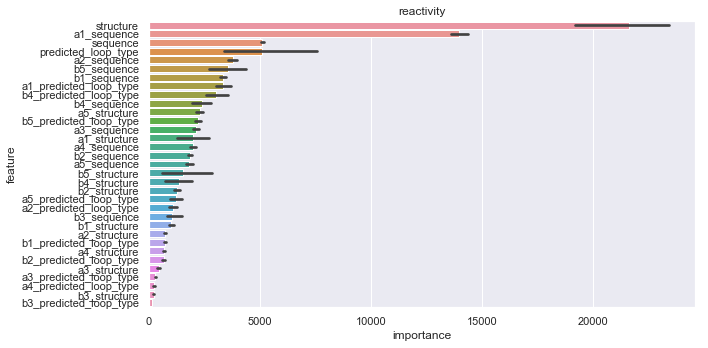

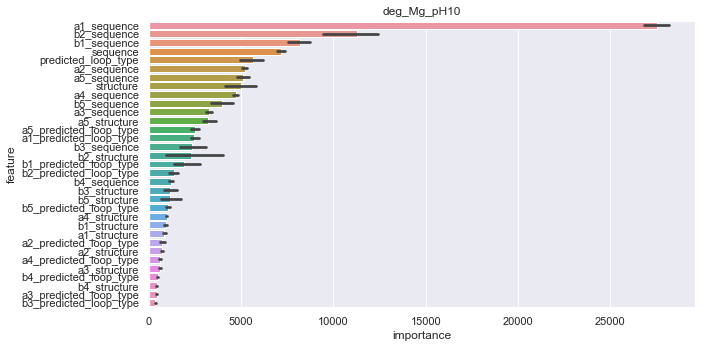

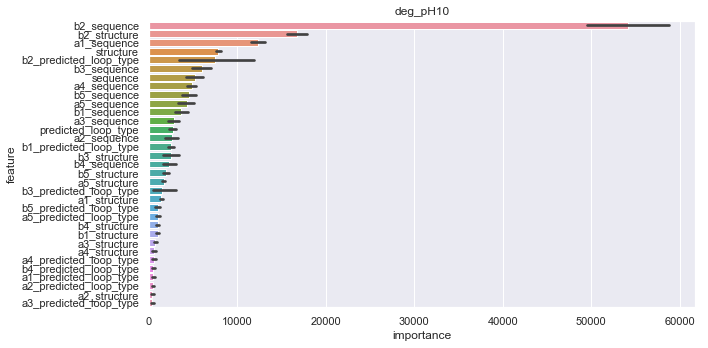

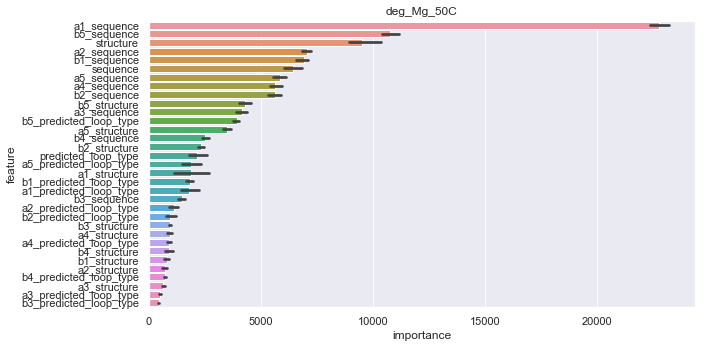

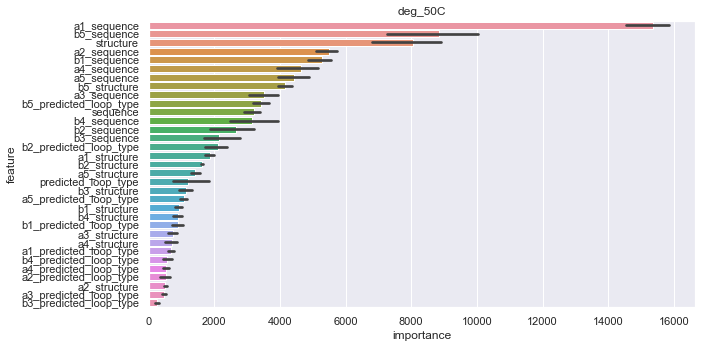

In [18]:
# feature_importances
for target in targets:
    tmp = feature_importances[feature_importances.target==target]
    order = list(tmp.groupby('feature').mean().sort_values('importance', ascending=False).index)

    plt.figure(figsize=(10, 5))
    sns.barplot(x="importance", y="feature", data=tmp, order=order)
    plt.title(target)
    plt.tight_layout()

In [19]:
oof_df.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081_0,0.616442,0.665550,1.916537,0.714803,0.879351
1,id_001f94081_1,2.303293,2.866084,3.713927,2.895127,2.220306
2,id_001f94081_2,1.272562,0.574761,0.923325,0.384020,0.804021
3,id_001f94081_3,1.168985,1.164618,1.313576,1.635008,1.196757
4,id_001f94081_4,0.735236,0.564976,0.684158,0.765982,0.812214


In [20]:
submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.621139,0.581613,2.001467,0.504587,0.670596
1,id_00073f8be_1,2.361492,2.900790,3.759561,3.079152,2.289518
2,id_00073f8be_2,1.429418,0.789183,1.097869,0.848550,0.984391
3,id_00073f8be_3,1.267935,0.975199,1.189719,1.576153,1.543442
4,id_00073f8be_4,0.754725,0.528866,0.566465,0.866136,0.842299


In [21]:
display(oof_df.shape)
display(submission.shape)

(163200, 6)

(457953, 6)

In [23]:
oof_df.to_csv('oof_df.csv', index=False)
submission.to_csv('submission.csv', index=False)